In [1]:
#import

import sys
import time
from time import strftime
import datetime
from calendar import monthrange

import numpy as np
import pandas as pd
import pandas_datareader.data as datareader

import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

random_state = 42
np.random.seed(random_state)

In [2]:
df = pd.read_csv('data_momentum.csv')

In [3]:
dfmom = df[['Date','Symbols','return_1m','return_2m', 'return_12m']]

In [4]:
dfmom

,Date,Symbols,return_1m,return_2m,return_12m
0,2011-01-31,ACN,0.061456,0.090016,0.020737
1,2011-01-31,ADBE,0.073749,0.090343,0.001915
2,2011-01-31,AMD,-0.042787,0.036375,0.004042
3,2011-01-31,AKAM,0.026993,-0.037790,0.057513
4,2011-01-31,APH,0.048503,0.051878,0.027876
...,...,...,...,...,...
7555,2020-12-31,V,0.039838,0.097973,0.013259
7556,2020-12-31,WDC,0.234180,0.211636,-0.009558
7557,2020-12-31,WU,-0.017908,0.067573,-0.013185
7558,2020-12-31,XLNX,-0.025970,0.094463,0.032759


In [5]:
uniquedates = sorted(dfmom["Date"].unique())
display(uniquedates[:10])
display(uniquedates[-10:])

['2011-01-31',
 '2011-02-28',
 '2011-03-31',
 '2011-04-30',
 '2011-05-31',
 '2011-06-30',
 '2011-07-31',
 '2011-08-31',
 '2011-09-30',
 '2011-10-31']

['2020-03-31',
 '2020-04-30',
 '2020-05-31',
 '2020-06-30',
 '2020-07-31',
 '2020-08-31',
 '2020-09-30',
 '2020-10-31',
 '2020-11-30',
 '2020-12-31']

In [6]:
num_buckets = 8

def bucket_df_by_col(df, col, num_buckets=num_buckets):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    tempvals=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_buckets quantiles
    vals = pd.qcut(tempvals, num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df

In [7]:
dflist = []
for d in uniquedates:
    tempdf = dfmom[dfmom["Date"]==d].copy() # to avoid bucketing on a slice
    dflist.append(bucket_df_by_col(tempdf, "return_12m"))
datanew= pd.concat(dflist)
display(datanew.head())
display(datanew.tail())

,Date,Symbols,return_1m,return_2m,return_12m,return_12m_RANK
0,2011-01-31,ACN,0.061456,0.090016,0.020737,3
1,2011-01-31,ADBE,0.073749,0.090343,0.001915,1
2,2011-01-31,AMD,-0.042787,0.036375,0.004042,1
3,2011-01-31,AKAM,0.026993,-0.037790,0.057513,7
4,2011-01-31,APH,0.048503,0.051878,0.027876,3


,Date,Symbols,return_1m,return_2m,return_12m,return_12m_RANK
7555,2020-12-31,V,0.039838,0.097973,0.013259,2
7556,2020-12-31,WDC,0.234180,0.211636,-0.009558,0
7557,2020-12-31,WU,-0.017908,0.067573,-0.013185,0
7558,2020-12-31,XLNX,-0.025970,0.094463,0.032759,5
7559,2020-12-31,ZBRA,0.015617,0.164041,0.034629,6


In [8]:
def maxdrawdown(series):
    """max drawdown of a cumulative return series"""
    return (series / series.cummax() -1).min()

# todo: longest period of underperformance, worst vs.index

def portmetrics_monthly(ret, rf):
    "given monthly return, monthly risk-free return as series, return portfolio metrics dataframe"

    annret = (1 + ret).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized return: %f" % annret)

    annvol = ret.std() * np.sqrt(12)
    print("annualized volatility: %f" % annvol)

    #annualized excess return
    annexcess = (1 + ret - rf).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized excess return: %f" % annexcess)

    # sharpe
    sharpe = annexcess / annvol
    print("Sharpe: %f" % sharpe)

    return pd.DataFrame({"Metric" : ["Annualized return","Annualized volatility","Sharpe"] , 
                         "Value": [annret, annvol, sharpe]})

def sharpe(ret, rf):
    "given monthly return, monthly risk-free return as series, return Sharpe"
    annvol = ret.std() * np.sqrt(12)
    excess_series = 1 + ret - rf
    # cumulative return at end of series
    excess = excess_series.cumprod().iloc[-1] 
    annexcess = excess ** (12/len(ret)) - 1
    sharpe = annexcess / annvol
    return sharpe


#change input parameters
def turnover(data):
    """data has gvkeys, datetime, assumed equal weight, datedf = unique dates"""
    datedf = data.groupby("Date").count().reset_index()[["Date","Symbols"]]
    datedf["EqualWeight"] = 1/datedf["Symbols"]
    datedf.head()
    
    turnover_list = []
    for i in range(1, len(datedf["Date"])):
        date0 = datedf["Date"][i-1]
        t0 = data.loc[data["Date"]==date0][["Symbols", "EqualWeights"]]

        date1 = datedf["Date"][i]
        t1 = data.loc[data["Date"]==date1][["Symbols", "EqualWeights"]]

        turnover_df = t0.merge(t1, on=["Symbols"], how='outer',suffixes=["_t0","_t1"])    
        turnover_df.fillna(0, inplace=True)
        turnover_list.append(np.abs(turnover_df["EqualWeight_t0"] - turnover_df["EqualWeight_t1"]).sum()/2)

In [9]:
first_months = 60

class Backtestmodel():
    def __init__ (self,
              df,
              create_model = None,
              startindex = first_months,
              scaler = None,
              fit_missing = None):
    
        self.data = df.copy()
        self.data.sort_values(['Date', 'Symbols'], inplace = True)
        self.data.reset_index(inplace=True)
        self.data['Index'] = self.data.index
        
        self.uniquedates = self.data[['Date', 'Index']].groupby('Date').first().reset_index()
        self.uniquedatelist = list(self.uniquedates['Index'])
        self.data['Index'] = self.data.index
        
        self.y = df.iloc[:, -1]
        self.x = df.iloc[:, 2:-1]
        self.xrows, self.xcols = self.x.shape
        self.p = np.zeros_like(self.y)
        
        self.xscale = self.x.copy()
        self.yscale = self.y.copy()
        
        if scaler:
            print('scaler: %s' %str(scaler))
            self.xscale = scaler().fit_transform(self.xscale)
            self.yscale = scaler().fit_transform(self.yscale)
        self.create_model = create_model
        self.startindex = startindex
        self.fit_missing = fit_missing
        
    def fit_predict(self, train_months, predicts_month=1, verbose=False):
        train_stop_index = self.uniquedatelist[train_months]
        if verbose:
            print('Training months: 0:%d, indexes 0:%d' % (train_months-1, train_stop_index-1))
        x_fit = self.xscale[:train_stop_index]
        y_fit = self.yscale[:train_stop_index]
            
        self.model = self.create_model()
        self.model.fit(x_fit, y_fit)
            
        if train_months + predicts_month > len(self.uniquedatelist)-1:
            predict_stop_index = len (self.xscale)
        else:
            predict_stop_index = self.uniquedatelist[train_months + predicts_month]
            
        x_predict = self.xscale[train_stop_index:predict_stop_index]
        y_predict = self.model.predict(x_predict)
            
        self.p[train_stop_index:predict_stop_index] = y_predict
            
        return self.p
        
    def gen_predictions_regression(self, 
                                   step = 1, 
                                   split = None, 
                                   verbose = False):
        print('Staring Training')
        
        if split:
            month_indexes = split[:-1]
        else:
            month_indexes = list(range(self.startindex, len(self.uniquedatelist), step))
            
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        steps.append(len(self.uniquedatelist) - month_indexes[-1])
        
        if verbose:
            print('Months:' + str(month_indexes))
            print('Steps:' + str(steps))
        
        progress_i = 0
        
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d months (%d:%d), storing predictions in rows %s" % (month_index,
                                                                                               0, month_indexes-1,
                                                                                               str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=verbose)
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print('')
                print('%s Still training step %d of %d' %strftime('%H:%M:%S'), progress_i, len (month_indexes))
            sys.stdout.flush()
        print('')
        print('%s Finished training' % (strftime('%H:%M:%S')))
        
            

In [10]:
n_estimators = 300
max_depth = 14
sub_sample = 0.7
colsample_bytree = 1/3
learning_rate = 0.1
gamma = 0 

def xgboost_model():
    return xgboost.XGBRegressor(n_estimators=n_estimators,
                        max_depth = max_depth,
                        sub_sample = sub_sample,
                        colsample_bytree = colsample_bytree,
                        learning_rate = learning_rate,
                        gamma = gamma
                        )



backtestmodel = Backtestmodel(df[['Date', 'Symbols', 'return_12m', 'return_2m']],
                              create_model=xgboost_model,
                              startindex=first_months,
                             )

backtestmodel.gen_predictions_regression(verbose=False)

Staring Training
[11:03:16] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:03:19] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:03:23] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above 

.[11:04:34] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:04:37] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:04:40] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:04

.[11:06:03] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:06:07] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:06:11] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


.[11:06

In [11]:
data2 = backtestmodel.data.copy()
data2['return_1m'] = df['return_1m']
data2['P'] = backtestmodel.p
data2.head()

,index,Date,Symbols,return_12m,return_2m,Index,return_1m,P
0,7,2011-01-31,AAPL,0.048571,0.044287,0,0.061456,0.0
1,0,2011-01-31,ACN,0.020737,0.090016,1,0.073749,0.0
2,1,2011-01-31,ADBE,0.001915,0.090343,2,-0.042787,0.0
3,5,2011-01-31,ADI,0.033297,0.048215,3,0.026993,0.0
4,10,2011-01-31,ADP,0.016229,0.040720,4,0.048503,0.0


In [12]:
dateindexes = data2.groupby(["Date"])["Index"].first()

In [13]:
data3 = None
for d in dateindexes.index[first_months:]:
    tempdf = data2.loc[data2["Date"]==d]
    print(d, len(tempdf))
    tempdf["PREDRANK"] = pd.qcut(tempdf["P"], num_buckets, labels=False)
    if data3 is None:
        data3 = tempdf
    else:
        data3 = pd.concat([data3, tempdf])
data3.head()

2016-01-31 63
2016-02-29 63
2016-03-31 63
2016-04-30 63
2016-05-31 63
2016-06-30 63
2016-07-31 63
2016-08-31 63
2016-09-30 63
2016-10-31 63
2016-11-30 63
2016-12-31 63
2017-01-31 63
2017-02-28 63
2017-03-31 63
2017-04-30 63
2017-05-31 63
2017-06-30 63


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

2017-07-31 63
2017-08-31 63
2017-09-30 63
2017-10-31 63
2017-11-30 63
2017-12-31 63
2018-01-31 63
2018-02-28 63
2018-03-31 63
2018-04-30 63
2018-05-31 63
2018-06-30 63
2018-07-31 63
2018-08-31 63
2018-09-30 63
2018-10-31 63
2018-11-30 63
2018-12-31 63
2019-01-31 63
2019-02-28 63


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

2019-03-31 63
2019-04-30 63
2019-05-31 63
2019-06-30 63
2019-07-31 63
2019-08-31 63
2019-09-30 63
2019-10-31 63
2019-11-30 63
2019-12-31 63
2020-01-31 63
2020-02-29 63
2020-03-31 63
2020-04-30 63
2020-05-31 63
2020-06-30 63
2020-07-31 63
2020-08-31 63
2020-09-30 63


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

2020-10-31 63
2020-11-30 63
2020-12-31 63


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,Date,Symbols,return_12m,return_2m,Index,return_1m,P,PREDRANK
3780,3787,2016-01-31,AAPL,-0.013938,-0.092904,3780,0.009952,-0.009537,1
3781,3780,2016-01-31,ACN,0.020987,-0.007865,3781,-0.051203,0.000470,3
3782,3781,2016-01-31,ADBE,0.020180,-0.012820,3782,-0.233449,-0.060858,0
3783,3785,2016-01-31,ADI,0.005031,-0.062109,3783,-0.133194,0.035873,6
3784,3790,2016-01-31,ADP,0.002577,-0.015520,3784,-0.050929,0.032673,5


In [14]:
data3.head()

,index,Date,Symbols,return_12m,return_2m,Index,return_1m,P,PREDRANK
3780,3787,2016-01-31,AAPL,-0.013938,-0.092904,3780,0.009952,-0.009537,1
3781,3780,2016-01-31,ACN,0.020987,-0.007865,3781,-0.051203,0.000470,3
3782,3781,2016-01-31,ADBE,0.020180,-0.012820,3782,-0.233449,-0.060858,0
3783,3785,2016-01-31,ADI,0.005031,-0.062109,3783,-0.133194,0.035873,6
3784,3790,2016-01-31,ADP,0.002577,-0.015520,3784,-0.050929,0.032673,5


In [15]:
data3.to_csv('predicted_dataframe.csv')

In [16]:
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

In [17]:
dates_df.head()

,Index,t0,t1,t2
Date,,,,
2011-01-31,0,2011-01-31,2011-02-28,2011-03-31
2011-02-28,63,2011-02-28,2011-03-31,2011-04-30
2011-03-31,126,2011-03-31,2011-04-30,2011-05-31
2011-04-30,189,2011-04-30,2011-05-31,2011-06-30
2011-05-31,252,2011-05-31,2011-06-30,2011-07-31


In [18]:
data3['Date1'] = dates_df.loc[data3['Date']]['t1'].values
data3['Date2'] = dates_df.loc[data3['Date']]['t2'].values

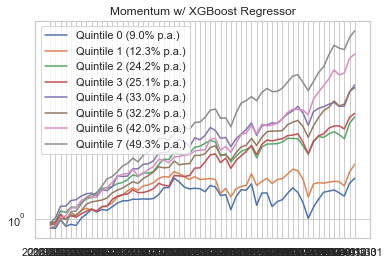

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,8.97,25.02,-0.13
1,Quintile 1,12.28,21.00,-0.02
2,Quintile 2,24.19,19.14,0.53
3,Quintile 3,25.14,18.85,0.59
4,Quintile 4,32.98,20.80,0.87
5,Quintile 5,32.24,17.15,1.01
6,Quintile 6,42.01,19.46,1.31
7,Quintile 7,49.28,20.81,1.52


In [19]:
reportdict = {'Label': [],
              'Annualized return': [],
              'Annualized volatility': [],
             'Sharpe': []}


for i in range(num_buckets):
    T0 = data3.loc[data3['PREDRANK']==i]
    T1 = T0[['Date1', 'Symbols']].merge(data3, how='left',
                                       left_on = ['Date1', 'Symbols'],
                                       right_on = ['Date', 'Symbols'])[['Date', 'Symbols', 'return_1m']]
    T2 = T0[['Date2', 'Symbols']].merge(data3, how='left',
                                       left_on = ['Date2', 'Symbols'],
                                       right_on = ['Date2', 'Symbols']) [['Date', 'Symbols', 'return_1m']]
    T2.sort_values(['Date', 'Symbols']).tail()
    
    G0 = T0[['Date', 'return_1m']].groupby('Date').mean()
    G1 = T1[['Date', 'return_1m']].groupby('Date').mean()
    G2 = T2[['Date', 'return_1m']].groupby('Date').mean()
    
    G_all = pd.merge(G1,G2, on = 'Date', how = 'outer', suffixes = ['1', '2'])
    G_all = pd.merge(G_all, G0, on = 'Date', how = 'outer').sort_values('Date').reset_index()

    tempdf = pd.DataFrame(G_all[['Date', 'return_1m']])
    
    tempdf['Ret1p'] = 1 + tempdf['return_1m']
    tempdf['Cumret'] = tempdf['Ret1p'].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf['rf'] = 0.01
    
    lastval = list(tempdf['Cumret'])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf['Cumret'].pct_change().std() * np.sqrt(12) * 100
    
    reportdict['Label'].append('Quintile %d' %(i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe['return_1m'], tempdf_sharpe['rf']))
    
    tempdf.set_index('Date', inplace=True)
    plt.semilogy(tempdf['Cumret'], label = 'Quintile %d (%.1f%% p.a.)' % (i, annret));
    
plt.legend();
plt.title('Momentum w/ XGBoost Regressor')
plt.show()
    
with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))

In [20]:
tempdf

,index,return_1m,Ret1p,Cumret,rf
Date,,,,,
2016-01-31,0,-0.099246,0.900754,0.900754,0.01
2016-02-29,1,0.016260,1.016260,0.915400,0.01
2016-03-31,2,0.084967,1.084967,0.993179,0.01
2016-04-30,3,-0.070355,0.929645,0.923304,0.01
2016-05-31,4,0.163245,1.163245,1.074028,0.01
2016-06-30,5,0.009766,1.009766,1.084517,0.01
2016-07-31,6,0.076103,1.076103,1.167052,0.01
2016-08-31,7,0.072734,1.072734,1.251937,0.01
2016-09-30,8,0.032312,1.032312,1.292389,0.01
